### Data Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

In [2]:
# Load và khám phá dữ liệu
with open('C:/Users/DELL/Tiki_ABSA/src/models/DistilBert/data/v2_labeled_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Tổng số reviews: {len(data)}")
print(f"Cấu trúc của một review mẫu:")
print(json.dumps(data[0], indent=2, ensure_ascii=False))

Tổng số reviews: 4039
Cấu trúc của một review mẫu:
{
  "text": "Mua hàng chiều ngày 06032023. Nhận hàng sáng ngày 07032023 Ly màu hồng có hoạ tiết giá 272,000 Ly màu đen giá 233,000 Giảm giá được 20,000 Hôm nay nhận 2 ly này là ly thứ 6 rồi. Nắp cải tiến so với mẫu cũ khá tiện lợi vì chỉ cần bật qua phải nhấn là mở nắp. Có 1 vấn đề nhỏ là nếu miếng lò xo ở nắp gãy hoặc rỉ sét thì khi mở nắp chắc phải xoay mở luôn nắp bự ra mới uống được. Chất lượng giữ nhiệt với mình là ổn. Vỏ ly dễ trầy xước nếu bị rơi, va đập. Hàng của Look Look thì đẹp, chất lượng. Tiki giao hàng nhanh. Mình đánh giá 5 và sẽ mua tiếp những lần sau.",
  "labels": [
    [
      140,
      185,
      "Nắp cải tiến so với mẫu cũ khá tiện lợi vì chỉ cần bật qua phải nhấn là mở nắp.",
      "Chất lượng sản phẩm#Tích cực"
    ],
    [
      187,
      290,
      "Có 1 vấn đề nhỏ là nếu miếng lò xo ở nắp gãy hoặc rỉ sét thì khi mở nắp chắc phải xoay mở luôn nắp bự ra mới uống được.",
      "Chất lượng sản phẩm#Tiêu cực"
   

In [3]:
# Tạo DataFrame cho reviews
reviews_df = pd.DataFrame([{
    'review_id': i,
    'text': item['text'],
    'text_length': len(item['text']),
    'num_labels': len(item['labels'])
} for i, item in enumerate(data)])

In [7]:
labels_data = []

for review_id, item in enumerate(data):
    for label in item.get('labels', []):
        if len(label) < 4:
            print(f"[Cảnh báo] Label không đủ phần tử tại review {review_id}: {label}")
            continue

        start_pos, end_pos, text_snippet, aspect_sentiment = label
        aspect = ''
        sentiment = None  # Mặc định là None nếu không có phần sau '#'

        if isinstance(aspect_sentiment, str):
            parts = aspect_sentiment.split('#')
            if len(parts) >= 1:
                aspect = parts[0].strip()
            if len(parts) == 2:
                sentiment = parts[1].strip()

        labels_data.append({
            'review_id': review_id,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'text_snippet': text_snippet,
            'aspect_sentiment': aspect_sentiment,
            'aspect': aspect,
            'sentiment': sentiment
        })

labels_df = pd.DataFrame(labels_data)
labels_df


,review_id,start_pos,end_pos,text_snippet,aspect_sentiment,aspect,sentiment
0,0,140,185,Nắp cải tiến so với mẫu cũ khá tiện lợi vì chỉ...,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực
1,0,187,290,Có 1 vấn đề nhỏ là nếu miếng lò xo ở nắp gãy h...,Chất lượng sản phẩm#Tiêu cực,Chất lượng sản phẩm,Tiêu cực
2,0,291,323,Chất lượng giữ nhiệt với mình là ổn.,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực
3,0,324,360,"Vỏ ly dễ trầy xước nếu bị rơi, va đập.",Chất lượng sản phẩm#Tiêu cực,Chất lượng sản phẩm,Tiêu cực
4,0,361,390,"Hàng của Look Look thì đẹp, chất lượng.",Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực
...,...,...,...,...,...,...,...
12437,4036,37,58,Chất âm ổn trong tầm giá,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực
12438,4036,60,76,Sạc nhanh xài lâu,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực
12439,4037,0,13,Dễ kết nối,Khác#Tích cực,Khác,Tích cực
12440,4037,15,27,âm thanh nghe ổn,Chất lượng sản phẩm#Tích cực,Chất lượng sản phẩm,Tích cực


### Basic Statistics

=== THỐNG KÊ REVIEWS ===
Số lượng reviews: 4039
Độ dài trung bình của review: 119.5 ký tự
Độ dài ngắn nhất: 16 ký tự
Độ dài dài nhất: 2225 ký tự
Số labels trung bình mỗi review: 3.1


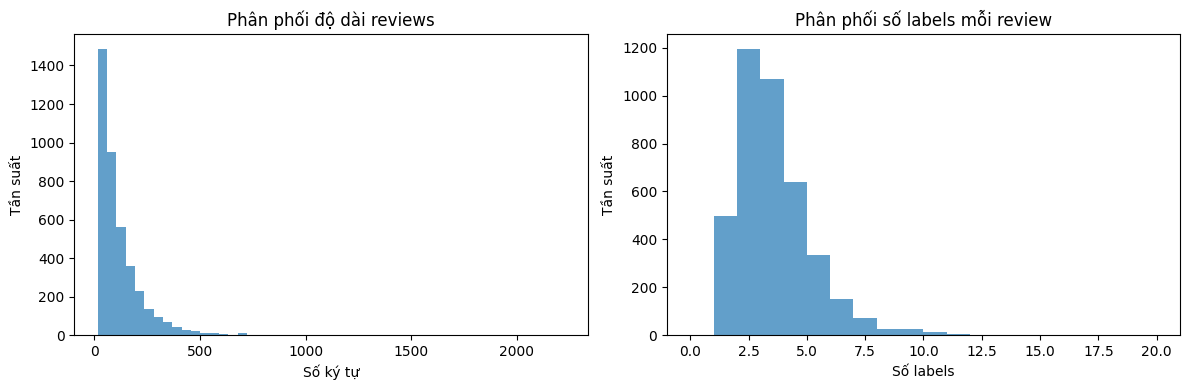

In [12]:
print("=== THỐNG KÊ REVIEWS ===")
print(f"Số lượng reviews: {len(reviews_df)}")
print(f"Độ dài trung bình của review: {reviews_df['text_length'].mean():.1f} ký tự")
print(f"Độ dài ngắn nhất: {reviews_df['text_length'].min()} ký tự")
print(f"Độ dài dài nhất: {reviews_df['text_length'].max()} ký tự")
print(f"Số labels trung bình mỗi review: {reviews_df['num_labels'].mean():.1f}")

# Phân phối độ dài reviews
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(reviews_df['text_length'], bins=50, alpha=0.7)
plt.title('Phân phối độ dài reviews')
plt.xlabel('Số ký tự')
plt.ylabel('Tần suất')

plt.subplot(1, 2, 2)
plt.hist(reviews_df['num_labels'], bins=20, alpha=0.7)
plt.title('Phân phối số labels mỗi review')
plt.xlabel('Số labels')
plt.ylabel('Tần suất')
plt.tight_layout()
plt.show()

In [10]:
print("\n=== THỐNG KÊ LABELS ===")
print(f"Tổng số labels: {len(labels_df)}")
print(f"Số aspects unique: {labels_df['aspect'].nunique()}")
print(f"Số sentiment classes: {labels_df['sentiment'].nunique()}")


=== THỐNG KÊ LABELS ===
Tổng số labels: 12442
Số aspects unique: 4
Số sentiment classes: 3


=== PHÂN PHỐI ASPECTS ===
Chất lượng sản phẩm    7499
Dịch vụ                3159
Giá cả                  893
Khác                    891
Name: aspect, dtype: int64


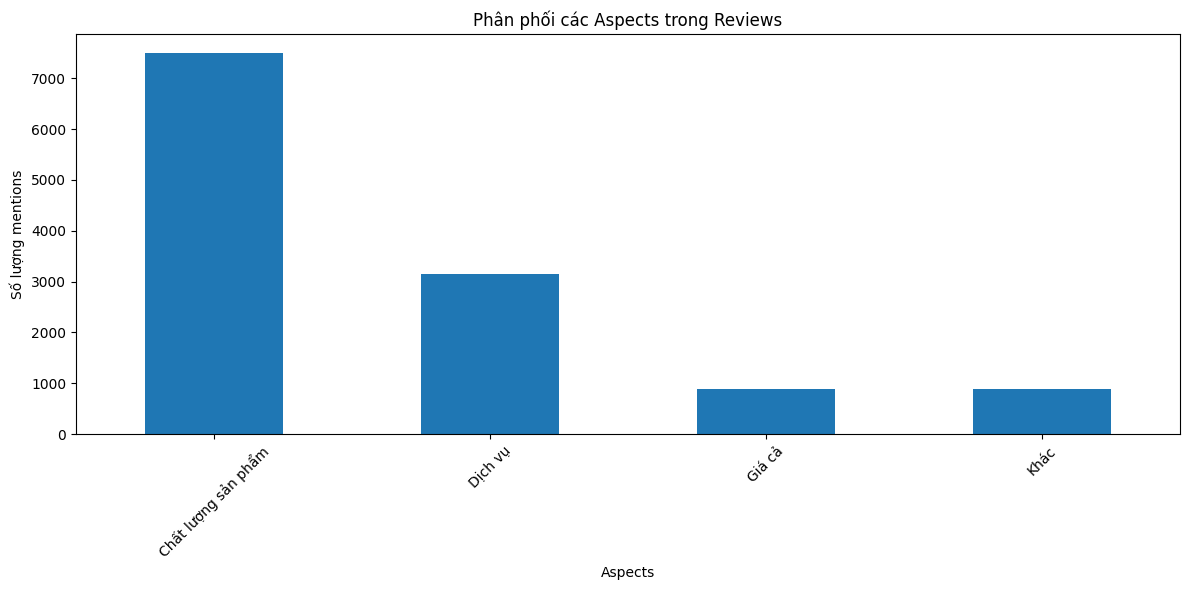

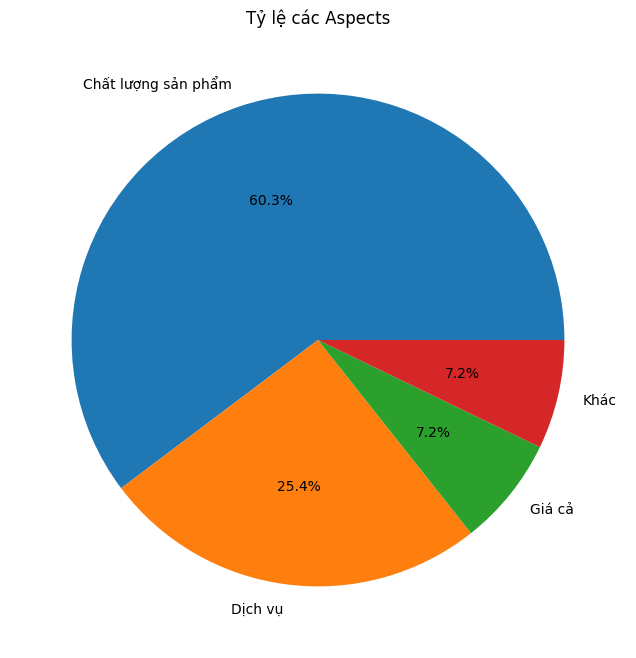

In [11]:
aspect_counts = labels_df['aspect'].value_counts()
print("=== PHÂN PHỐI ASPECTS ===")
print(aspect_counts)

# Visualization
plt.figure(figsize=(12, 6))
aspect_counts.plot(kind='bar')
plt.title('Phân phối các Aspects trong Reviews')
plt.xlabel('Aspects')
plt.ylabel('Số lượng mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(aspect_counts.values, labels=aspect_counts.index, autopct='%1.1f%%')
plt.title('Tỷ lệ các Aspects')
plt.show()

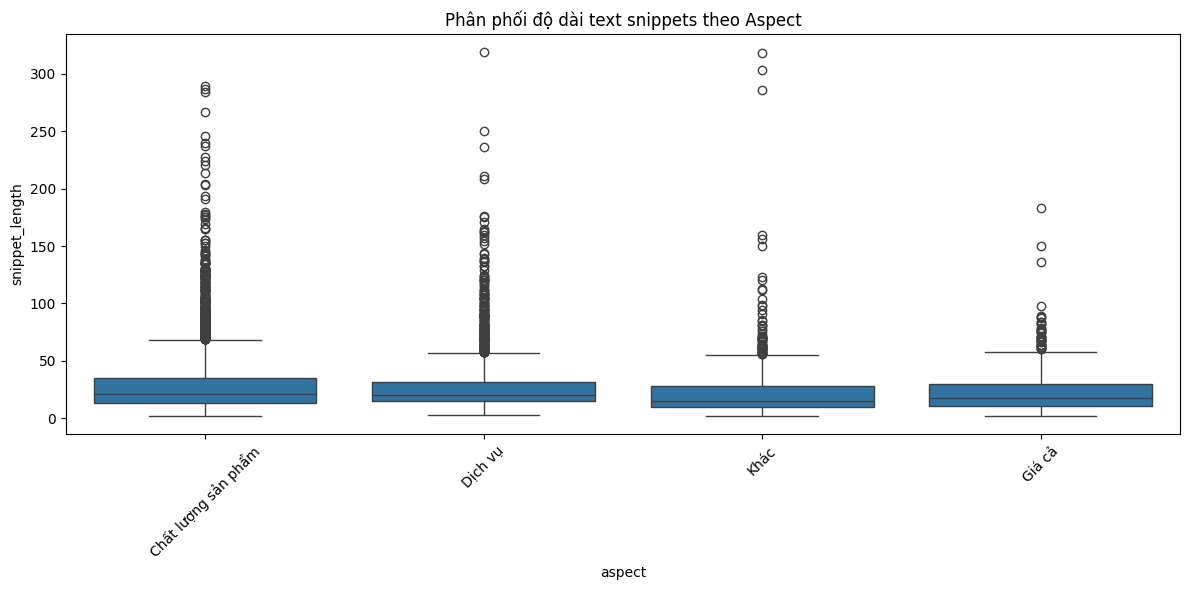

In [13]:
# Phân tích độ dài text snippets theo aspect
labels_df['snippet_length'] = labels_df['text_snippet'].str.len()

plt.figure(figsize=(12, 6))
sns.boxplot(data=labels_df, x='aspect', y='snippet_length')
plt.title('Phân phối độ dài text snippets theo Aspect')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== PHÂN PHỐI SENTIMENT ===
Tích cực       9848
Tiêu cực       1728
Bình thường     573
Name: sentiment, dtype: int64
Tỷ lệ Tích cực: 79.2%
Tỷ lệ Tiêu cực: 13.9%
Tỷ lệ Bình thường: 4.6%


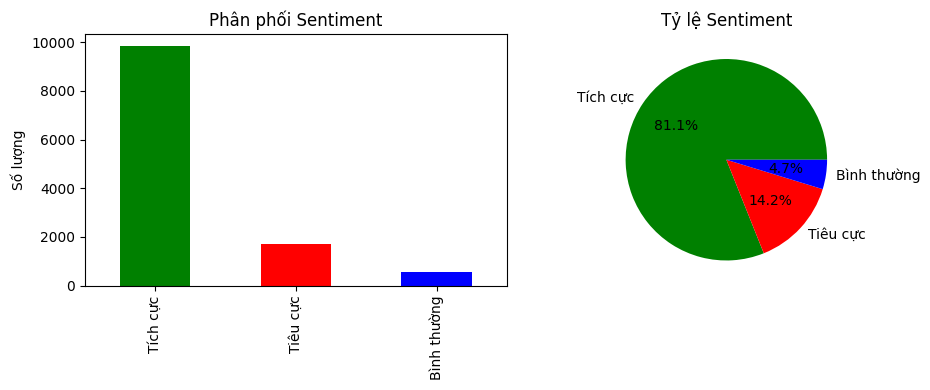

In [24]:
sentiment_counts = labels_df['sentiment'].value_counts()
print("=== PHÂN PHỐI SENTIMENT ===")
print(sentiment_counts)
print(f"Tỷ lệ Tích cực: {sentiment_counts.get('Tích cực', 0)/len(labels_df)*100:.1f}%")
print(f"Tỷ lệ Tiêu cực: {sentiment_counts.get('Tiêu cực', 0)/len(labels_df)*100:.1f}%")
print(f"Tỷ lệ Bình thường: {sentiment_counts.get('Bình thường', 0)/len(labels_df)*100:.1f}%")

# Visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Phân phối Sentiment')
plt.ylabel('Số lượng')

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, 
        autopct='%1.1f%%', colors=['green', 'red', 'blue'])
plt.title('Tỷ lệ Sentiment')
plt.tight_layout()
plt.show()

In [16]:
# Cross-tabulation
aspect_sentiment = pd.crosstab(labels_df['aspect'], labels_df['sentiment'])
print("=== SENTIMENT THEO ASPECT ===")
print(aspect_sentiment)

# Tỷ lệ phần trăm
aspect_sentiment_pct = pd.crosstab(labels_df['aspect'], labels_df['sentiment'], normalize='index') * 100
print("\n=== TỶ LỆ PHẦN TRĂM ===")
print(aspect_sentiment_pct.round(1))

=== SENTIMENT THEO ASPECT ===
sentiment            Bình thường  Tiêu cực  Tích cực
aspect                                              
Chất lượng sản phẩm          426      1119      5954
Dịch vụ                       70       447      2642
Giá cả                        57        77       759
Khác                          20        85       493

=== TỶ LỆ PHẦN TRĂM ===
sentiment            Bình thường  Tiêu cực  Tích cực
aspect                                              
Chất lượng sản phẩm          5.7      14.9      79.4
Dịch vụ                      2.2      14.2      83.6
Giá cả                       6.4       8.6      85.0
Khác                         3.3      14.2      82.4


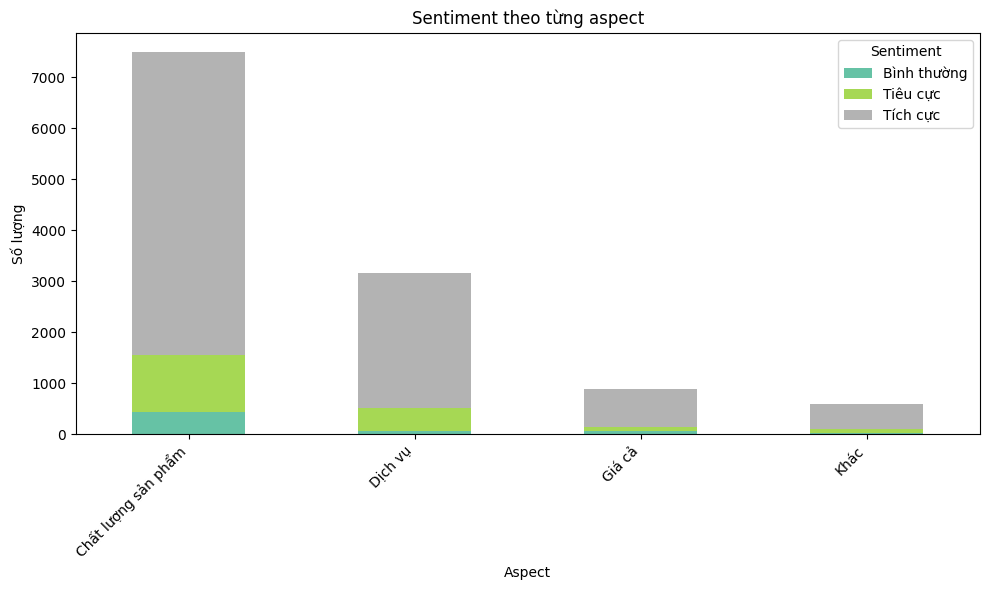

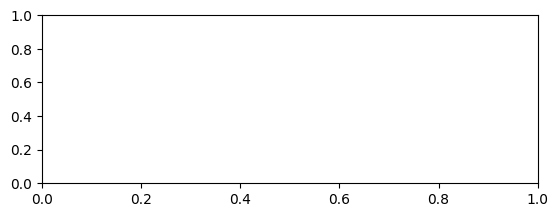

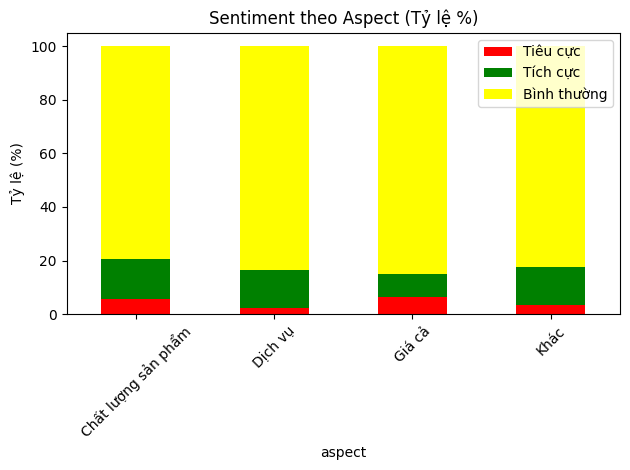

In [23]:
# Visualization
aspect_sentiment.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10, 6))

plt.title("Sentiment theo từng aspect")
plt.xlabel("Aspect")
plt.ylabel("Số lượng")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


plt.subplot(2, 1, 2)
aspect_sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'green', 'yellow'])
plt.title('Sentiment theo Aspect (Tỷ lệ %)')
plt.legend(['Tiêu cực', 'Tích cực', 'Bình thường'])
plt.xticks(rotation=45)
plt.ylabel('Tỷ lệ (%)')
plt.tight_layout()
plt.show()

### Text Mining Analysis

In [26]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re

# Tiền xử lý text
def preprocess_text(text):
    # Loại bỏ số, ký tự đặc biệt, chỉ giữ chữ cái tiếng Việt
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

# Tạo corpus cho mỗi sentiment
positive_texts = labels_df[labels_df['sentiment'] == 'Tích cực']['text_snippet'].apply(preprocess_text)
negative_texts = labels_df[labels_df['sentiment'] == 'Tiêu cực']['text_snippet'].apply(preprocess_text)
neutral_texts = labels_df[labels_df['sentiment'] == 'Bình thường']['text_snippet'].apply(preprocess_text)

# Word frequency analysis
def get_top_words(texts, n=20):
    vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
    word_freq = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    frequencies = word_freq.sum(axis=0).A1
    word_freq_dict = dict(zip(feature_names, frequencies))
    return sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:n]

In [27]:
print("=== TOP WORDS - TÍCH CỰC ===")
positive_words = get_top_words(positive_texts)
for word, freq in positive_words:
    print(f"{word}: {freq}")


=== TOP WORDS - TÍCH CỰC ===
hàng: 1875
giao: 1477
nhanh: 1439
rất: 1187
tốt: 1082
giao hàng: 1051
sản: 752
phẩm: 742
sản phẩm: 728
hàng nhanh: 696
gói: 660
không: 643
giá: 627
đóng: 614
đóng gói: 592
chất: 569
tiki: 538
lượng: 527
đẹp: 515
chất lượng: 507


In [28]:
print("\n=== TOP WORDS - TIÊU CỰC ===")
negative_words = get_top_words(negative_texts)
for word, freq in negative_words:
    print(f"{word}: {freq}")


=== TOP WORDS - TIÊU CỰC ===
không: 610
hàng: 312
có: 278
hơi: 273
bị: 229
được: 191
giao: 187
là: 157
thì: 141
mình: 136
khi: 120
nên: 116
quá: 110
mua: 105
tiki: 100
hộp: 99
sản: 99
mà: 96
phẩm: 96
và: 96


In [29]:
print("\n=== TOP WORDS - BÌNH THƯỜNG ===")
neutral_words = get_top_words(neutral_texts)
for word, freq in neutral_words:
    print(f"{word}: {freq}")


=== TOP WORDS - BÌNH THƯỜNG ===
không: 170
có: 109
chưa: 101
biết: 87
được: 87
thì: 78
chất: 64
giá: 63
lượng: 61
nên: 59
chất lượng: 57
dùng: 55
mình: 54
bền: 49
mới: 48
độ: 45
nhưng: 42
bình: 41
là: 41
phải: 41


(-0.5, 799.5, 399.5, -0.5)

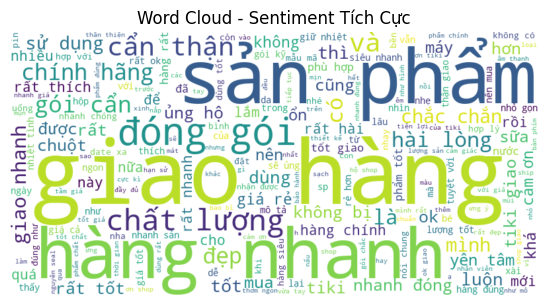

In [30]:
# Word cloud cho sentiment tích cực
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
positive_text = ' '.join(positive_texts)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Sentiment Tích Cực')
plt.axis('off')

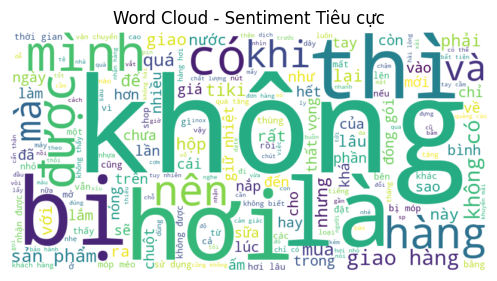

In [34]:
# Word cloud cho sentiment tiêu cực
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
negative_text = ' '.join(negative_texts)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Sentiment Tiêu cực')
plt.axis('off')
plt.tight_layout()
plt.show()

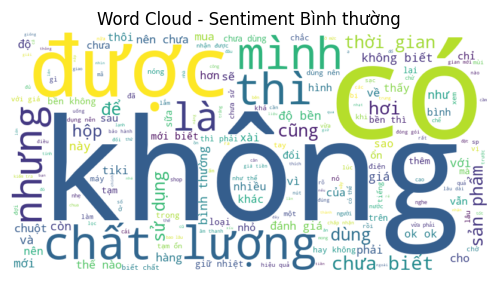

In [33]:
# Word cloud cho sentiment bình thường
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
neutral_text = ' '.join(neutral_texts)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Sentiment Bình thường')
plt.axis('off')
plt.tight_layout()
plt.show()

### Correlation and Pattern Analysis

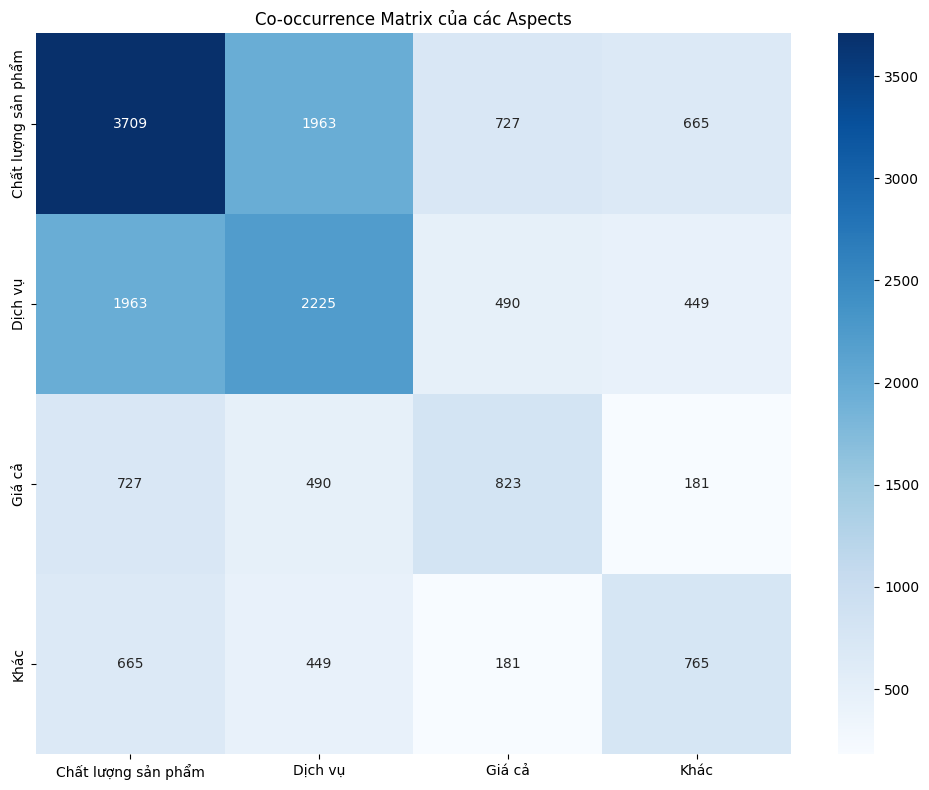

In [35]:
# Tạo matrix aspect co-occurrence
aspect_cooccurrence = pd.DataFrame(0, index=aspect_counts.index, columns=aspect_counts.index)

for review_id in labels_df['review_id'].unique():
    review_aspects = labels_df[labels_df['review_id'] == review_id]['aspect'].unique()
    for i, aspect1 in enumerate(review_aspects):
        for aspect2 in review_aspects[i:]:
            aspect_cooccurrence.loc[aspect1, aspect2] += 1
            if aspect1 != aspect2:
                aspect_cooccurrence.loc[aspect2, aspect1] += 1

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(aspect_cooccurrence, annot=True, cmap='Blues', fmt='d')
plt.title('Co-occurrence Matrix của các Aspects')
plt.tight_layout()
plt.show()

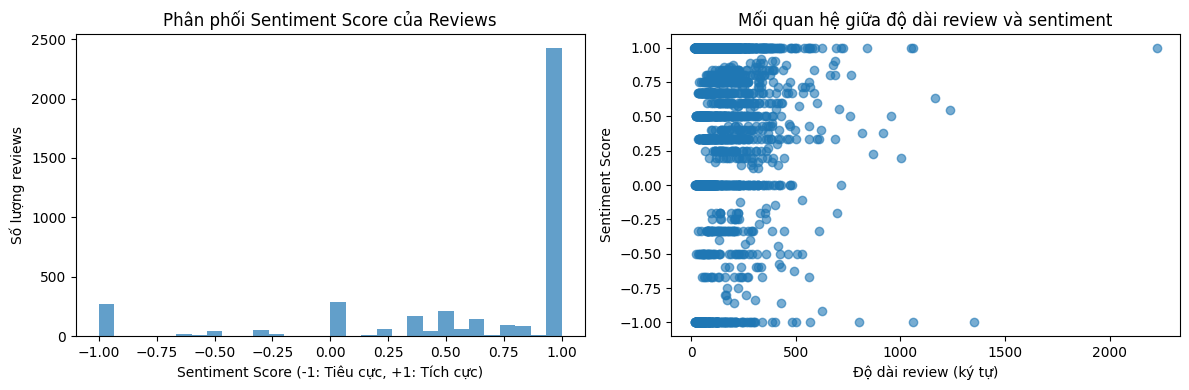

In [36]:
# Tính sentiment score cho mỗi review
review_sentiment_scores = []
for review_id in reviews_df['review_id']:
    review_labels = labels_df[labels_df['review_id'] == review_id]
    if len(review_labels) > 0:
        positive_count = (review_labels['sentiment'] == 'Tích cực').sum()
        negative_count = (review_labels['sentiment'] == 'Tiêu cực').sum()
        total_count = len(review_labels)
        sentiment_score = (positive_count - negative_count) / total_count
    else:
        sentiment_score = 0
    
    review_sentiment_scores.append({
        'review_id': review_id,
        'sentiment_score': sentiment_score,
        'positive_count': positive_count,
        'negative_count': negative_count,
        'total_aspects': total_count
    })

sentiment_df = pd.DataFrame(review_sentiment_scores)
reviews_df = reviews_df.merge(sentiment_df, on='review_id')

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(reviews_df['sentiment_score'], bins=30, alpha=0.7)
plt.title('Phân phối Sentiment Score của Reviews')
plt.xlabel('Sentiment Score (-1: Tiêu cực, +1: Tích cực)')
plt.ylabel('Số lượng reviews')

plt.subplot(1, 2, 2)
plt.scatter(reviews_df['text_length'], reviews_df['sentiment_score'], alpha=0.6)
plt.title('Mối quan hệ giữa độ dài review và sentiment')
plt.xlabel('Độ dài review (ký tự)')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

### Feature Engineering 

##### Text-based Features

In [42]:
# Cài đặt: pip install underthesea
from underthesea import text_normalize
import requests

def get_vietnamese_stopwords():
    """Danh sách Vietnamese stopwords được tạo thủ công - đầy đủ nhất"""
    
    vietnamese_stopwords = [
        # Đại từ nhân xưng
        'tôi', 'bạn', 'anh', 'chị', 'em', 'ông', 'bà', 'cô', 'chú', 'cậu', 'mày', 'tao',
        'nó', 'họ', 'chúng', 'mình', 'ta', 'chúng ta', 'chúng tôi', 'các bạn',
        
        # Đại từ chỉ định
        'này', 'kia', 'đó', 'đây', 'ấy', 'nọ', 'kìa',
        
        # Động từ tobe và trợ động từ
        'là', 'thì', 'mà', 'được', 'có', 'không', 'chưa', 'đã', 'sẽ', 'đang', 'vừa',
        'bị', 'cho', 'của', 'do', 'để', 'trong', 'ngoài', 'trên', 'dưới', 'giữa',
        
        # Liên từ
        'và', 'với', 'cùng', 'hoặc', 'hay', 'nhưng', 'mà', 'song', 'tuy', 'dù', 'dẫu',
        'nếu', 'giả sử', 'vì', 'bởi vì', 'do đó', 'nên', 'cho nên', 'vậy', 'thế',
        
        # Giới từ
        'về', 'từ', 'đến', 'tại', 'ở', 'bằng', 'theo', 'dọc', 'qua', 'ra', 'vào',
        'lên', 'xuống', 'sang', 'tới', 'đi', 'lại', 'về phía', 'hướng về',
        
        # Trạng từ
        'rất', 'lắm', 'nhiều', 'ít', 'hơn', 'nữa', 'thêm', 'bớt', 'cũng', 'luôn',
        'chỉ', 'chỉ có', 'chỉ là', 'duy nhất', 'đơn thuần', 'thuần túy', 'hoàn toàn',
        'tuyệt đối', 'khá', 'khá là', 'tương đối', 'hơi', 'hơi hơi', 'thật',
        
        # Từ hỏi
        'gì', 'ai', 'đâu', 'nào', 'sao', 'thế nào', 'ra sao', 'bao giờ', 'khi nào',
        'tại sao', 'vì sao', 'tại làm sao', 'làm gì', 'bao nhiêu', 'mấy',
        
        # Từ phủ định
        'không', 'chưa', 'chẳng', 'đâu có', 'đâu phải', 'chả', 'khỏi', 'thôi',
        
        # Từ thời gian
        'hôm nay', 'ngày mai', 'hôm qua', 'tuần này', 'tuần trước', 'tuần sau',
        'tháng này', 'tháng trước', 'tháng sau', 'năm này', 'năm ngoái', 'năm sau',
        'sáng', 'trưa', 'chiều', 'tối', 'khuya', 'đêm', 'sớm', 'muộn',
        'bây giờ', 'lúc này', 'hiện tại', 'trước đây', 'sau này', 'tương lai',
        
        # Từ số lượng
        'một', 'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín', 'mười',
        'mười một', 'mười hai', 'hai mười', 'ba mười', 'trăm', 'nghìn', 'triệu', 'tỷ',
        'đôi', 'cặp', 'số', 'vài', 'một số', 'một vài', 'nhiều', 'ít', 'tất cả', 'mọi',
        
        # Thán từ và từ nhấn mạnh
        'ồ', 'ô', 'ơ', 'ố', 'ộ', 'ờ', 'à', 'ạ', 'ạ', 'ừ', 'ử', 'ủ', 'hả', 'hử', 'gì',
        'thế', 'ấy', 'vậy', 'như vậy', 'như thế', 'thế này', 'vậy này',
        
        # Từ logic và kết nối
        'nếu', 'thì', 'thế thì', 'vậy thì', 'như vậy thì', 'do đó', 'cho nên', 'vì thế',
        'bởi vậy', 'nên', 'mà', 'nhưng mà', 'song', 'tuy nhiên', 'tuy vậy', 'dù vậy',
        
        # Từ bổ nghĩa
        'khá', 'rất', 'lắm', 'hết sức', 'vô cùng', 'cực kỳ', 'vô cùng tận', 'hơi',
        'tương đối', 'bình thường', 'thông thường', 'thường', 'thỉnh thoảng', 'đôi khi',
        
        # Các từ khác thường gặp
        'cái', 'con', 'chiếc', 'quả', 'trái', 'hòn', 'viên', 'tờ', 'cuốn', 'quyển',
        'cây', 'cành', 'lá', 'bông', 'hoa', 'trái', 'quả',
        'ông', 'bà', 'anh', 'chị', 'em', 'cô', 'dì', 'chú', 'bác', 'thím',
        
        # Từ chỉ vị trí, hướng
        'đây', 'đó', 'kia', 'này', 'nọ', 'bên', 'cạnh', 'gần', 'xa', 'trong', 'ngoài',
        'trên', 'dưới', 'trước', 'sau', 'giữa', 'khắp', 'suốt', 'dọc', 'ngang',
        
        # Từ chỉ trạng thái
        'đang', 'đã', 'sẽ', 'vừa', 'mới', 'cũ', 'cũ rồi', 'rồi', 'xong', 'xong rồi',
        
        # Từ chỉ mức độ so sánh
        'hơn', 'kém', 'bằng', 'như', 'giống', 'giống như', 'không bằng', 'không như',
        'tốt hơn', 'kém hơn', 'bằng nhau', 'ngang nhau',
        
        # Từ chuyên dụng trong review
        'sản phẩm', 'hàng', 'đồ', 'thứ', 'loại', 'kiểu', 'dạng', 'món', 'cái',
        'shop', 'cửa hàng', 'nhà', 'công ty', 'thương hiệu', 'brand', 'mình',
        'giao hàng', 'ship', 'shipping', 'đóng gói', 'bao bì', 'hộp'
    ]
    
    return vietnamese_stopwords


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textstat import flesch_reading_ease
import string
from collections import Counter

def extract_text_features(df):
    """Extract comprehensive text features"""
    
    text_features = []
    
    for idx, row in df.iterrows():
        text = row['text']
        
        # Basic text statistics
        features = {
            'text_length': len(text),
            'word_count': len(text.split()),
            'sentence_count': text.count('.') + text.count('!') + text.count('?'),
            'char_count': len(text.replace(' ', '')),
            'avg_word_length': np.mean([len(word) for word in text.split()]),
            'punct_count': sum([1 for char in text if char in string.punctuation]),
            'upper_count': sum([1 for char in text if char.isupper()]),
            'digit_count': sum([1 for char in text if char.isdigit()]),
        }
        
        # Advanced text features
        vietnamese_stopwords = get_vietnamese_stopwords()
        words = text.split()
        features.update({
            'unique_word_ratio': len(set(words)) / len(words) if words else 0,
            'stopword_ratio': len([w for w in words if w.lower() in vietnamese_stopwords]) / len(words) if words else 0,
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'caps_ratio': sum([1 for char in text if char.isupper()]) / len(text) if text else 0,
        })
        
        # Sentiment lexicon features
        positive_words = ['tốt', 'đẹp', 'chất lượng', 'nhanh', 'tiện', 'ổn', 'thích', 'hài lòng']
        negative_words = ['xấu', 'chậm', 'tệ', 'lỗi', 'hỏng', 'khó', 'không tốt', 'thất vọng']
        neutral_words = ['bình thường', 'tạm ổn', 'được', 'không sao', 'không rõ', 'chờ thời gian', 'chưa dùng', 'chưa sài', 'tiền nào của nấy']

        
        features.update({
            'positive_word_count': sum([1 for word in positive_words if word in text.lower()]),
            'negative_word_count': sum([1 for word in negative_words if word in text.lower()]),
            'neutral_word_count': sum([1 for word in neutral_words if word in text.lower()]),
            #'sentiment_word_ratio': (features.get('positive_word_count', 0) - features.get('negative_word_count', 0)) / len(words) if words else 0
            'sentiment_word_ratio': ( features.get('positive_word_count',0)- features.get('negative_word_count',0)) / (features.get('neutral_word_count',0) + 1)  # thêm 1 để tránh chia 0
        })
        
        text_features.append(features)
    
    return pd.DataFrame(text_features)

# Áp dụng feature extraction
text_features_df = extract_text_features(reviews_df)
reviews_extended = pd.concat([reviews_df, text_features_df], axis=1)

print("=== TEXT FEATURES EXTRACTED ===")
print(text_features_df.describe())

=== TEXT FEATURES EXTRACTED ===
       text_length   word_count  sentence_count   char_count  avg_word_length  \
count  4039.000000  4039.000000      4039.00000  4039.000000      4039.000000   
mean    119.481307    26.793266         1.68210    93.688042         3.578534   
std     120.087301    27.272098         2.88743    92.912706         0.553782   
min      16.000000     5.000000         0.00000    12.000000         2.000000   
25%      45.000000    10.000000         0.00000    36.000000         3.333333   
50%      83.000000    18.000000         1.00000    65.000000         3.516129   
75%     151.000000    34.000000         2.00000   118.000000         3.750000   
max    2225.000000   500.000000        87.00000  1726.000000        21.785714   

       punct_count  upper_count  digit_count  unique_word_ratio  \
count  4039.000000  4039.000000  4039.000000        4039.000000   
mean      3.350582     2.452835     0.933399           0.945632   
std       3.813364     4.790685     2

##### Aspect-based Features

In [53]:
def extract_aspect_features(reviews_df, labels_df):
    """Extract aspect-based features for each review"""

    aspect_features = []

    for review_id in reviews_df['review_id']:
        review_labels = labels_df[labels_df['review_id'] == review_id]

        # Basic aspect statistics
        features = {
            'num_aspects': len(review_labels),
            'num_unique_aspects': review_labels['aspect'].nunique(),
            'aspect_diversity': review_labels['aspect'].nunique() / len(review_labels) if len(review_labels) > 0 else 0,
        }

        # Aspect-specific counts
        aspect_counts = review_labels['aspect'].value_counts()
        for aspect in labels_df['aspect'].unique():
            features[f'aspect_{aspect}_count'] = aspect_counts.get(aspect, 0)

        # Sentiment distribution
        sentiment_counts = review_labels['sentiment'].value_counts()
        pos = sentiment_counts.get('Tích cực', 0)
        neg = sentiment_counts.get('Tiêu cực', 0)
        neu = sentiment_counts.get('Trung lập', 0)

        total = pos + neg + neu

        features.update({
            'positive_aspects': pos,
            'negative_aspects': neg,
            'neutral_aspects': neu,

            'sentiment_ratio': (pos - neg) / total if total > 0 else 0,
            'sentiment_balance': min(pos, neg) / max(pos, neg) if max(pos, neg) > 0 else 0,

            # Optional: tỷ lệ trung lập so với tất cả
            'neutral_ratio': neu / total if total > 0 else 0
        })

        # Position-based features
        if len(review_labels) > 0:
            text_length = len(reviews_df.loc[reviews_df['review_id'] == review_id, 'text'].iloc[0])
            features.update({
                'first_aspect_position': min(review_labels['start_pos']) / text_length,
                'last_aspect_position': max(review_labels['end_pos']) / text_length,
                'aspect_span_coverage': (max(review_labels['end_pos']) - min(review_labels['start_pos'])) / text_length
            })
        else:
            features.update({
                'first_aspect_position': 0,
                'last_aspect_position': 0,
                'aspect_span_coverage': 0
            })

        aspect_features.append(features)

    return pd.DataFrame(aspect_features)

# Extract aspect features
aspect_features_df = extract_aspect_features(reviews_df, labels_df)
reviews_extended = pd.concat([reviews_extended, aspect_features_df], axis=1)

print("=== ASPECT FEATURES EXTRACTED ===")
print(aspect_features_df.describe())


=== ASPECT FEATURES EXTRACTED ===
       num_aspects  num_unique_aspects  aspect_diversity  \
count  4039.000000         4039.000000       4039.000000   
mean      3.080465            1.862342          0.691769   
std       1.645747            0.781070          0.268611   
min       0.000000            0.000000          0.000000   
25%       2.000000            1.000000          0.500000   
50%       3.000000            2.000000          0.666667   
75%       4.000000            2.000000          1.000000   
max      20.000000            4.000000          1.000000   

       aspect_Chất lượng sản phẩm_count  aspect_Dịch vụ_count  \
count                       4039.000000           4039.000000   
mean                           1.856648              0.782124   
std                            1.352634              0.889411   
min                            0.000000              0.000000   
25%                            1.000000              0.000000   
50%                            1.00

##### N-gram và TF-IDF Features

In [55]:
def create_ngram_features(texts, max_features=1000, ngram_range=(1, 2)):
    """Create n-gram features using TF-IDF"""
    
    # Preprocess texts
    processed_texts = [preprocess_text(text) for text in texts]
    
    # TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words= get_vietnamese_stopwords() if 'vietnamese_stopwords' in globals() else None,
        lowercase=True,
        token_pattern=r'\b\w+\b'
    )
    
    tfidf_matrix = tfidf.fit_transform(processed_texts)
    feature_names = [f'tfidf_{name}' for name in tfidf.get_feature_names_out()]
    
    return pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names), tfidf

# Create TF-IDF features for reviews
tfidf_features, tfidf_vectorizer = create_ngram_features(reviews_df['text'])

print("=== TF-IDF FEATURES ===")
print(f"Shape: {tfidf_features.shape}")
print(f"Top features: {list(tfidf_features.columns[:10])}")

# Create TF-IDF features for aspect snippets
snippet_tfidf_features, snippet_tfidf_vectorizer = create_ngram_features(labels_df['text_snippet'], max_features=500)
print(f"Snippet TF-IDF shape: {snippet_tfidf_features.shape}")

=== TF-IDF FEATURES ===
Shape: (4039, 1000)
Top features: ['tfidf_a', 'tfidf_ai', 'tfidf_an', 'tfidf_an toàn', 'tfidf_an tâm', 'tfidf_anh', 'tfidf_ban', 'tfidf_bao', 'tfidf_bao bì', 'tfidf_biết']
Snippet TF-IDF shape: (12442, 500)


##### Temporal và Metadata Features

In [56]:
import re
from datetime import datetime

def extract_temporal_features(texts):
    """Extract temporal and metadata features from review texts"""
    
    temporal_features = []
    
    for text in texts:
        features = {}
        
        # Extract dates
        date_patterns = [
            r'\d{1,2}/\d{1,2}/\d{4}',  # DD/MM/YYYY
            r'\d{8}',  # DDMMYYYY
            r'\d{1,2}\d{1,2}\d{4}'  # DDMMYYYY
        ]
        
        dates_found = []
        for pattern in date_patterns:
            dates_found.extend(re.findall(pattern, text))
        
        features['num_dates_mentioned'] = len(dates_found)
        features['mentions_delivery_time'] = 1 if any(word in text.lower() for word in ['giao', 'nhận', 'ship']) else 0
        features['mentions_price'] = 1 if any(word in text.lower() for word in ['giá', 'tiền', 'đồng', 'nghìn']) else 0
        features['mentions_quantity'] = 1 if any(word in text.lower() for word in ['ly', 'cái', 'chiếc', 'hộp']) else 0
        
        # Extract numbers (prices, quantities)
        numbers = re.findall(r'\d+', text)
        features['num_numbers'] = len(numbers)
        features['max_number'] = max([int(n) for n in numbers]) if numbers else 0
        features['min_number'] = min([int(n) for n in numbers]) if numbers else 0
        
        # Brand mentions
        common_brands = ['locknlock', 'tiki', 'apple', 'samsung', 'xiaomi']
        features['brand_mentions'] = sum([1 for brand in common_brands if brand in text.lower()])
        
        temporal_features.append(features)
    
    return pd.DataFrame(temporal_features)

# Extract temporal features
temporal_features_df = extract_temporal_features(reviews_df['text'])
reviews_extended = pd.concat([reviews_extended, temporal_features_df], axis=1)

print("=== TEMPORAL FEATURES ===")
print(temporal_features_df.describe())

=== TEMPORAL FEATURES ===
       num_dates_mentioned  mentions_delivery_time  mentions_price  \
count          4039.000000             4039.000000     4039.000000   
mean              0.011637                0.455063        0.220847   
std               0.195576                0.498038        0.414869   
min               0.000000                0.000000        0.000000   
25%               0.000000                0.000000        0.000000   
50%               0.000000                0.000000        0.000000   
75%               0.000000                1.000000        0.000000   
max               6.000000                1.000000        1.000000   

       mentions_quantity  num_numbers    max_number    min_number  \
count        4039.000000  4039.000000  4.039000e+03  4.039000e+03   
mean            0.119336     0.580837  1.152293e+05  4.877451e+03   
std             0.324224     1.300870  4.675428e+06  2.138568e+05   
min             0.000000     0.000000  0.000000e+00  0.000000e+00  

##### Linguistic Features

In [57]:
def extract_linguistic_features(texts):
    """Extract linguistic features"""
    
    linguistic_features = []
    
    for text in texts:
        features = {}
        
        # POS-like features (simplified for Vietnamese)
        words = text.split()
        
        # Count different types of words (heuristic-based)
        adjectives = ['tốt', 'xấu', 'đẹp', 'chậm', 'nhanh', 'dễ', 'khó', 'tiện', 'lợi']
        verbs = ['mua', 'bán', 'giao', 'nhận', 'dùng', 'sử dụng', 'thích', 'ghét']
        nouns = ['hàng', 'sản phẩm', 'chất lượng', 'giá', 'tiền', 'dịch vụ']
        
        features.update({
            'adj_count': sum([1 for word in words if any(adj in word.lower() for adj in adjectives)]),
            'verb_count': sum([1 for word in words if any(verb in word.lower() for verb in verbs)]),
            'noun_count': sum([1 for word in words if any(noun in word.lower() for noun in nouns)]),
        })
        
        # Readability features
        sentences = text.split('.')
        features.update({
            'avg_sentence_length': np.mean([len(sent.split()) for sent in sentences if sent.strip()]),
            'sentence_length_std': np.std([len(sent.split()) for sent in sentences if sent.strip()]),
            'complex_sentence_ratio': sum([1 for sent in sentences if len(sent.split()) > 15]) / len(sentences) if sentences else 0
        })
        
        # Repetition features
        word_counts = Counter(words)
        features.update({
            'max_word_freq': max(word_counts.values()) if word_counts else 0,
            'repeated_words_count': sum([1 for count in word_counts.values() if count > 1]),
            'repetition_ratio': sum([count for count in word_counts.values() if count > 1]) / len(words) if words else 0
        })
        
        linguistic_features.append(features)
    
    return pd.DataFrame(linguistic_features)

# Extract linguistic features
linguistic_features_df = extract_linguistic_features(reviews_df['text'])
reviews_extended = pd.concat([reviews_extended, linguistic_features_df], axis=1)

print("=== LINGUISTIC FEATURES ===")
print(linguistic_features_df.describe())

=== LINGUISTIC FEATURES ===
         adj_count   verb_count   noun_count  avg_sentence_length  \
count  4039.000000  4039.000000  4039.000000          4039.000000   
mean      0.938351     1.122308     0.902699            13.731127   
std       1.157234     1.218723     1.098060            10.568869   
min       0.000000     0.000000     0.000000             1.666667   
25%       0.000000     0.000000     0.000000             7.000000   
50%       1.000000     1.000000     1.000000            10.666667   
75%       1.000000     2.000000     1.000000            17.000000   
max      39.000000    11.000000    12.000000           117.000000   

       sentence_length_std  complex_sentence_ratio  max_word_freq  \
count          4039.000000             4039.000000    4039.000000   
mean              2.526104                0.266554       1.801931   
std               4.534766                0.374580       1.308670   
min               0.000000                0.000000       1.000000   
25%  

##### Contextual và Sequential Features

In [59]:
def create_contextual_features(reviews_df, labels_df):
    """Create contextual features based on surrounding text"""
    
    contextual_features = []
    
    for _, row in labels_df.iterrows():
        review_text = reviews_df[reviews_df['review_id'] == row['review_id']]['text'].iloc[0]
        start_pos, end_pos = row['start_pos'], row['end_pos']
        
        # Context windows
        context_window = 50  # characters
        left_context = review_text[max(0, start_pos-context_window):start_pos]
        right_context = review_text[end_pos:min(len(review_text), end_pos+context_window)]
        
        features = {
            'label_id': f"{row['review_id']}_{start_pos}_{end_pos}",
            'aspect_length': end_pos - start_pos,
            'relative_position': start_pos / len(review_text),
            'distance_from_start': start_pos,
            'distance_from_end': len(review_text) - end_pos,
        }
        
        # Context features
        features.update({
            'left_context_length': len(left_context),
            'right_context_length': len(right_context),
            'left_context_words': len(left_context.split()),
            'right_context_words': len(right_context.split()),
        })
        
        # Surrounding sentiment indicators
        positive_words = ['tốt', 'đẹp', 'chất lượng', 'nhanh', 'tiện']
        negative_words = ['xấu', 'chậm', 'tệ', 'lỗi', 'hỏng']
        neutral_words = ['không sao', 'không rõ', 'bình thường', 'OK', 'ok']
        
        context_text = left_context + ' ' + right_context
        features.update({
            'context_positive_words': sum([1 for word in positive_words if word in context_text.lower()]),
            'context_negative_words': sum([1 for word in negative_words if word in context_text.lower()]),
            'context_neutral_words': sum([1 for word in neutral_words if word in context_text.lower()]),
            'context_sentiment_score': sum([1 for word in positive_words if word in context_text.lower()]) - sum([1 for word in negative_words if word in context_text.lower()])
        })
        
        contextual_features.append(features)
    
    return pd.DataFrame(contextual_features)

# Create contextual features
contextual_features_df = create_contextual_features(reviews_df, labels_df)

print("=== CONTEXTUAL FEATURES ===")
print(contextual_features_df.describe())

=== CONTEXTUAL FEATURES ===
       aspect_length  relative_position  distance_from_start  \
count   12442.000000       12442.000000         12442.000000   
mean       22.163077           0.301008            52.316026   
std        17.731192           0.242371            74.481328   
min         1.000000           0.000000             0.000000   
25%        12.000000           0.000000             0.000000   
50%        17.000000           0.293611            29.000000   
75%        27.000000           0.500000            68.000000   
max       302.000000           1.050980          1123.000000   

       distance_from_end  left_context_length  right_context_length  \
count       12442.000000         12442.000000          12442.000000   
mean           89.849542            27.620318             36.586562   
std           124.740979            20.558836             17.051734   
min           -37.000000             0.000000              0.000000   
25%            22.000000             0.0

##### Feature Selection and Correlation Analysis

=== HIGH CORRELATION PAIRS ===
text_length - text_length: 1.000
text_length - word_count: 0.997
text_length - char_count: 1.000
text_length - repeated_words_count: 0.928
num_labels - total_aspects: 1.000
num_labels - num_aspects: 1.000
sentiment_score - sentiment_ratio: 0.977
positive_count - positive_aspects: 1.000
negative_count - negative_aspects: 1.000
total_aspects - num_aspects: 1.000
text_length - word_count: 0.997
text_length - char_count: 1.000
text_length - repeated_words_count: 0.928
word_count - char_count: 0.995
word_count - repeated_words_count: 0.933
sentence_count - punct_count: 0.863
char_count - repeated_words_count: 0.926
digit_count - num_numbers: 0.888
unique_word_ratio - max_word_freq: -0.837
unique_word_ratio - repetition_ratio: -0.981
last_aspect_position - aspect_span_coverage: 0.805

=== LOW VARIANCE FEATURES ===
Features with variance < 0.01: 5
['unique_word_ratio', 'caps_ratio', 'neutral_ratio', 'neutral_aspects', 'sentiment_word_ratio']

=== FEATURE STATIST

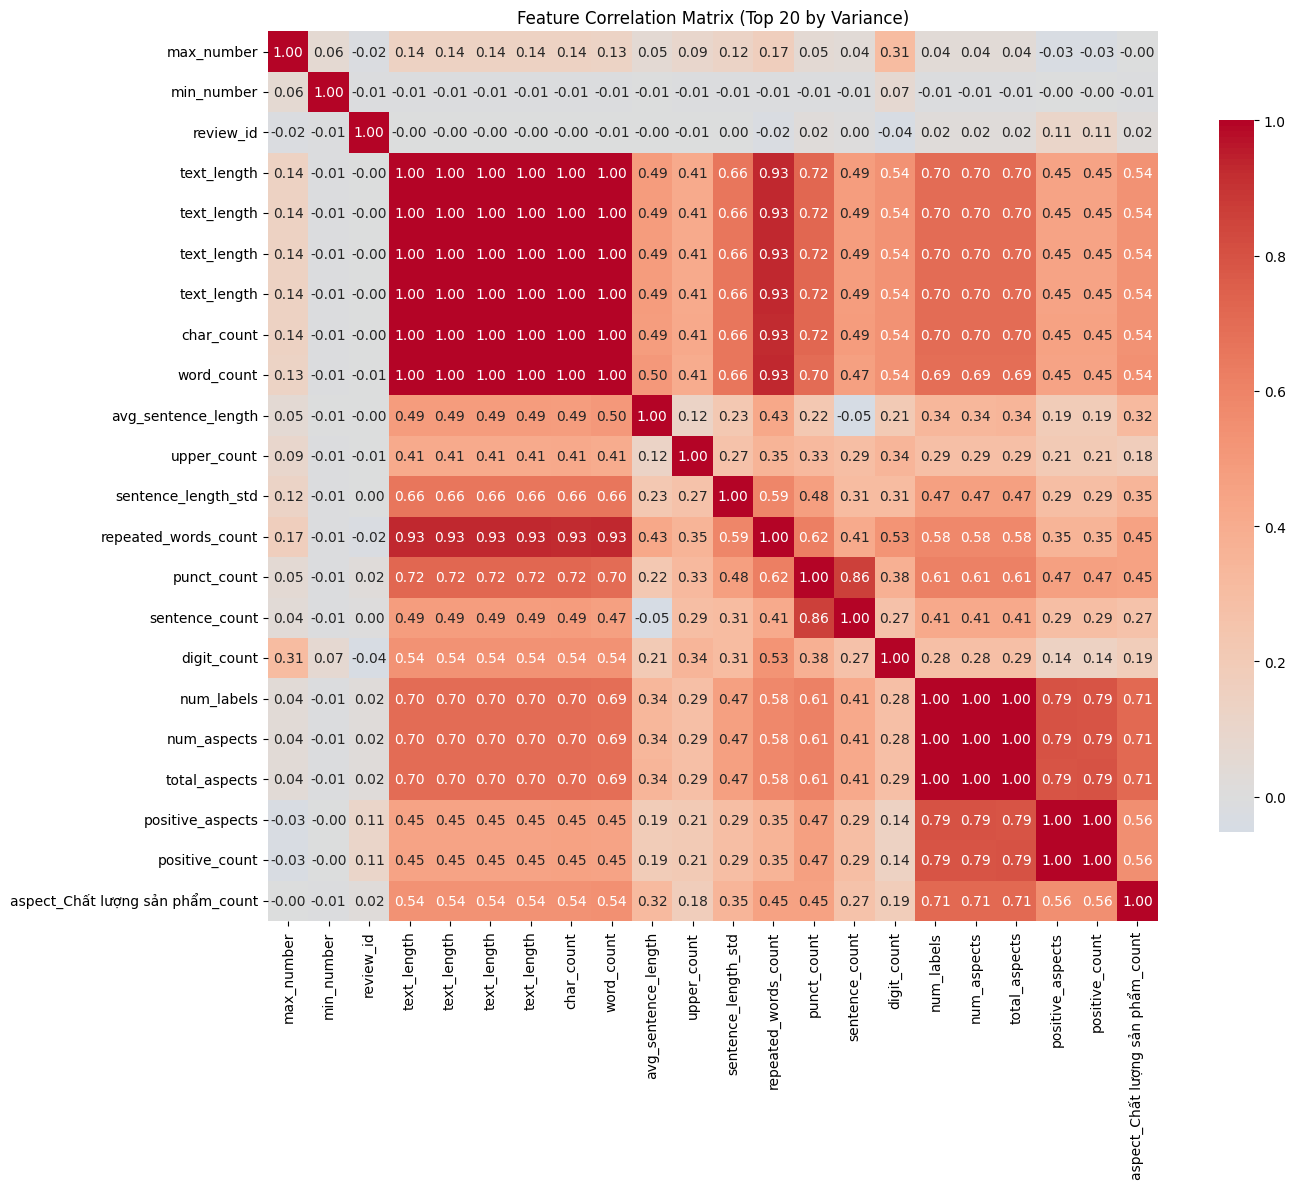

In [60]:
def analyze_feature_importance(features_df, target_col=None):
    """Analyze feature importance and correlations"""
    
    # Remove non-numeric columns
    numeric_features = features_df.select_dtypes(include=[np.number])
    
    # Correlation matrix
    corr_matrix = numeric_features.corr()
    
    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    
    print("=== HIGH CORRELATION PAIRS ===")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} - {feat2}: {corr:.3f}")
    
    # Feature variance
    feature_variance = numeric_features.var().sort_values(ascending=False)
    low_variance_features = feature_variance[feature_variance < 0.01].index.tolist()
    
    print(f"\n=== LOW VARIANCE FEATURES ===")
    print(f"Features with variance < 0.01: {len(low_variance_features)}")
    print(low_variance_features[:10] if len(low_variance_features) > 10 else low_variance_features)
    
    # Feature statistics
    print(f"\n=== FEATURE STATISTICS ===")
    print(f"Total features: {len(numeric_features.columns)}")
    print(f"Features with missing values: {numeric_features.isnull().sum().sum()}")
    print(f"Features with zero variance: {(numeric_features.var() == 0).sum()}")
    
    return corr_matrix, high_corr_pairs, low_variance_features

# Analyze all features
all_features = reviews_extended.select_dtypes(include=[np.number])
corr_matrix, high_corr_pairs, low_variance_features = analyze_feature_importance(all_features)

# Visualization
plt.figure(figsize=(15, 12))
# Select top 20 features by variance for visualization
top_features = all_features.var().nlargest(20).index
sns.heatmap(all_features[top_features].corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (Top 20 by Variance)')
plt.tight_layout()
plt.show()

##### Feature Engineering Pipeline

In [61]:
class FeatureEngineeringPipeline:
    def __init__(self):
        self.tfidf_vectorizer = None
        self.feature_columns = None
        self.scaler = None
    
    def fit_transform(self, reviews_df, labels_df):
        """Complete feature engineering pipeline"""
        
        print("Starting Feature Engineering Pipeline...")
        
        # 1. Text features
        print("1. Extracting text features...")
        text_features = extract_text_features(reviews_df)
        
        # 2. Aspect features
        print("2. Extracting aspect features...")
        aspect_features = extract_aspect_features(reviews_df, labels_df)
        
        # 3. Temporal features
        print("3. Extracting temporal features...")
        temporal_features = extract_temporal_features(reviews_df['text'])
        
        # 4. Linguistic features
        print("4. Extracting linguistic features...")
        linguistic_features = extract_linguistic_features(reviews_df['text'])
        
        # 5. TF-IDF features
        print("5. Creating TF-IDF features...")
        tfidf_features, self.tfidf_vectorizer = create_ngram_features(
            reviews_df['text'], max_features=500
        )
        
        # Combine all features
        all_features = pd.concat([
            reviews_df[['review_id']],
            text_features,
            aspect_features,
            temporal_features,
            linguistic_features,
            tfidf_features
        ], axis=1)
        
        # Handle missing values
        all_features = all_features.fillna(0)
        
        # Feature selection
        print("6. Feature selection...")
        numeric_features = all_features.select_dtypes(include=[np.number])
        
        # Remove low variance features
        from sklearn.feature_selection import VarianceThreshold
        variance_selector = VarianceThreshold(threshold=0.01)
        selected_features = variance_selector.fit_transform(numeric_features)
        
        self.feature_columns = numeric_features.columns[variance_selector.get_support()].tolist()
        final_features = pd.DataFrame(selected_features, columns=self.feature_columns)
        final_features['review_id'] = all_features['review_id'].values
        
        print(f"Final feature shape: {final_features.shape}")
        print(f"Features retained: {len(self.feature_columns)}")
        
        return final_features
    
    def transform(self, reviews_df, labels_df):
        """Transform new data using fitted pipeline"""
        # Apply same transformations as in fit_transform
        # (Implementation would follow same steps but use fitted transformers)
        pass

# Apply pipeline
pipeline = FeatureEngineeringPipeline()
final_features = pipeline.fit_transform(reviews_df, labels_df)

print("=== FEATURE ENGINEERING COMPLETE ===")
print(f"Final dataset shape: {final_features.shape}")
print("Sample features:")
print(final_features.head())

Starting Feature Engineering Pipeline...
1. Extracting text features...
2. Extracting aspect features...
3. Extracting temporal features...
4. Extracting linguistic features...
5. Creating TF-IDF features...
6. Feature selection...
Final feature shape: (4039, 46)
Features retained: 46
=== FEATURE ENGINEERING COMPLETE ===
Final dataset shape: (4039, 46)
Sample features:
   review_id  text_length  word_count  sentence_count  char_count  \
0          0        561.0       130.0             9.0       432.0   
1          1        336.0        75.0             6.0       262.0   
2          2        249.0        60.0             0.0       190.0   
3          3        502.0       115.0             2.0       388.0   
4          4        282.0        60.0             3.0       223.0   

   avg_word_length  punct_count  upper_count  digit_count  stopword_ratio  \
0         3.323077         14.0         15.0         37.0        0.284615   
1         3.493333         10.0          8.0          3.0  

##### Feature Validation and Export

In [62]:
def validate_features(features_df):
    """Validate engineered features"""
    
    validation_report = {
        'total_features': len(features_df.columns),
        'total_samples': len(features_df),
        'missing_values': features_df.isnull().sum().sum(),
        'infinite_values': np.isinf(features_df.select_dtypes(include=[np.number])).sum().sum(),
        'constant_features': (features_df.nunique() == 1).sum(),
        'feature_ranges': {}
    }
    
    # Check feature ranges
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        validation_report['feature_ranges'][col] = {
            'min': features_df[col].min(),
            'max': features_df[col].max(),
            'mean': features_df[col].mean(),
            'std': features_df[col].std()
        }
    
    print("=== FEATURE VALIDATION REPORT ===")
    print(f"Total features: {validation_report['total_features']}")
    print(f"Total samples: {validation_report['total_samples']}")
    print(f"Missing values: {validation_report['missing_values']}")
    print(f"Infinite values: {validation_report['infinite_values']}")
    print(f"Constant features: {validation_report['constant_features']}")
    
    return validation_report

# Validate features
validation_report = validate_features(final_features)

# Export features for model training
final_features.to_csv('C:/Users/DELL/Tiki_ABSA/notebooks/engineered_features.csv', index=False)
print("\nFeatures exported to 'engineered_features.csv'")

# Export feature metadata
feature_metadata = {
    'feature_columns': pipeline.feature_columns,
    'total_features': len(final_features.columns),
    'feature_types': {
        'text_features': [col for col in final_features.columns if any(x in col for x in ['length', 'count', 'ratio'])],
        'tfidf_features': [col for col in final_features.columns if 'tfidf_' in col],
        'aspect_features': [col for col in final_features.columns if 'aspect_' in col],
        'temporal_features': [col for col in final_features.columns if any(x in col for x in ['date', 'time', 'delivery'])],
        'linguistic_features': [col for col in final_features.columns if any(x in col for x in ['adj_', 'verb_', 'noun_'])]
    },
    'validation_report': validation_report
}

with open('C:/Users/DELL/Tiki_ABSA/notebooks/feature_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(feature_metadata, f, ensure_ascii=False, indent=2, default=str)

print("Feature metadata exported to 'feature_metadata.json'")

=== FEATURE VALIDATION REPORT ===
Total features: 46
Total samples: 4039
Missing values: 0
Infinite values: 0
Constant features: 0

Features exported to 'engineered_features.csv'
Feature metadata exported to 'feature_metadata.json'


### Summary and Insights

In [37]:
print("=== BÁO CÁO TỔNG KẾT EDA ===")
print(f"1. Tổng quan dataset:")
print(f"   - Số reviews: {len(reviews_df)}")
print(f"   - Số labels: {len(labels_df)}")
print(f"   - Số aspects: {labels_df['aspect'].nunique()}")
print(f"   - Độ dài trung bình review: {reviews_df['text_length'].mean():.0f} ký tự")

print(f"\n2. Phân bố Aspects:")
for aspect, count in aspect_counts.head().items():
    print(f"   - {aspect}: {count} ({count/len(labels_df)*100:.1f}%)")

print(f"\n3. Phân bố Sentiment:")
for sentiment, count in sentiment_counts.items():
    print(f"   - {sentiment}: {count} ({count/len(labels_df)*100:.1f}%)")

print(f"\n4. Insights chính:")
print(f"   - Aspect phổ biến nhất: {aspect_counts.index[0]}")
print(f"   - Tỷ lệ sentiment tích cực: {sentiment_counts.get('Tích cực', 0)/len(labels_df)*100:.1f}%")
print(f"   - Review có sentiment score trung bình: {reviews_df['sentiment_score'].mean():.2f}")

# Aspect có sentiment tích cực cao nhất
aspect_positivity = aspect_sentiment_pct['Tích cực'].sort_values(ascending=False)
print(f"   - Aspect tích cực nhất: {aspect_positivity.index[0]} ({aspect_positivity.iloc[0]:.1f}%)")
print(f"   - Aspect tiêu cực nhất: {aspect_positivity.index[-1]} ({aspect_positivity.iloc[-1]:.1f}%)")

=== BÁO CÁO TỔNG KẾT EDA ===
1. Tổng quan dataset:
   - Số reviews: 4039
   - Số labels: 12442
   - Số aspects: 4
   - Độ dài trung bình review: 119 ký tự

2. Phân bố Aspects:
   - Chất lượng sản phẩm: 7499 (60.3%)
   - Dịch vụ: 3159 (25.4%)
   - Giá cả: 893 (7.2%)
   - Khác: 891 (7.2%)

3. Phân bố Sentiment:
   - Tích cực: 9848 (79.2%)
   - Tiêu cực: 1728 (13.9%)
   - Bình thường: 573 (4.6%)

4. Insights chính:
   - Aspect phổ biến nhất: Chất lượng sản phẩm
   - Tỷ lệ sentiment tích cực: 79.2%
   - Review có sentiment score trung bình: 0.63
   - Aspect tích cực nhất: Giá cả (85.0%)
   - Aspect tiêu cực nhất: Chất lượng sản phẩm (79.4%)


###  Lưu Kết Quả EDA

In [70]:
# Lưu các thống kê chính
eda_results = {
    'dataset_stats': {
        'num_reviews': int(len(reviews_df)),
        'num_labels': int(len(labels_df)),
        'num_aspects': int(labels_df['aspect'].nunique()),
        'avg_review_length': float(reviews_df['text_length'].mean()),
        'avg_labels_per_review': float(reviews_df['num_labels'].mean())
    },
    'aspect_distribution': {str(k): int(v) for k, v in aspect_counts.to_dict().items()},
    'sentiment_distribution': {str(k): int(v) for k, v in sentiment_counts.to_dict().items()},
    'aspect_sentiment_matrix': {
        str(aspect): {str(sentiment): int(count) for sentiment, count in sentiment_dict.items()}
        for aspect, sentiment_dict in aspect_sentiment.to_dict().items()
    },
    'top_positive_words': positive_words,
    'top_negative_words': negative_words,
    'top_neutral_words': neutral_words
}

# Thêm phần kiểm tra kỹ hơn trong hàm convert_to_serializable
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.ndarray, pd.Series)):
        return [convert_to_serializable(i) for i in obj]
    elif isinstance(obj, dict):
        return {str(k) if not isinstance(k, (str, int, float, bool)) else k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(i) for i in obj]
    elif isinstance(obj, pd.DataFrame):
        return {str(k): convert_to_serializable(v) for k, v in obj.to_dict().items()}
    elif hasattr(obj, '__dict__'):
        return convert_to_serializable(obj.__dict__)
    else:
        return obj

# Áp dụng hàm convert_to_serializable một cách đệ quy
eda_results_serializable = convert_to_serializable(eda_results)

# Thử in ra để kiểm tra
print(eda_results_serializable)

# Lưu vào file JSON
with open('C:/Users/DELL/Tiki_ABSA/notebooks/eda_results.json', 'w', encoding='utf-8') as f:
    json.dump(eda_results_serializable, f, ensure_ascii=False, indent=2)
print(" Đã lưu kết quả EDA vào file 'eda_results.json'")

{'dataset_stats': {'num_reviews': 4039, 'num_labels': 12442, 'num_aspects': 4, 'avg_review_length': 119.48130725427086, 'avg_labels_per_review': 3.0804654617479574}, 'aspect_distribution': {'Chất lượng sản phẩm': 7499, 'Dịch vụ': 3159, 'Giá cả': 893, 'Khác': 891}, 'sentiment_distribution': {'Tích cực': 9848, 'Tiêu cực': 1728, 'Bình thường': 573}, 'aspect_sentiment_matrix': {'Bình thường': {'Chất lượng sản phẩm': 426, 'Dịch vụ': 70, 'Giá cả': 57, 'Khác': 20}, 'Tiêu cực': {'Chất lượng sản phẩm': 1119, 'Dịch vụ': 447, 'Giá cả': 77, 'Khác': 85}, 'Tích cực': {'Chất lượng sản phẩm': 5954, 'Dịch vụ': 2642, 'Giá cả': 759, 'Khác': 493}}, 'top_positive_words': [['hàng', 1875], ['giao', 1477], ['nhanh', 1439], ['rất', 1187], ['tốt', 1082], ['giao hàng', 1051], ['sản', 752], ['phẩm', 742], ['sản phẩm', 728], ['hàng nhanh', 696], ['gói', 660], ['không', 643], ['giá', 627], ['đóng', 614], ['đóng gói', 592], ['chất', 569], ['tiki', 538], ['lượng', 527], ['đẹp', 515], ['chất lượng', 507]], 'top_negati